# Perception-Gap Analysis – Random Forest on NOVA Group

This notebook performs error and interpretability analysis for the best-performing
Random Forest NOVA-group model, using the saved predictions and feature importance
from evaluation code.

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    precision_recall_fscore_support,
    accuracy_score,
    f1_score,
)

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

# Paths
RESULTS_DIR = "../results"
INTERP_DIR = os.path.join(RESULTS_DIR, "interpretability-nova")
os.makedirs(INTERP_DIR, exist_ok=True)

# Load test set with NOVA predictions
test = pd.read_csv(
    os.path.join(RESULTS_DIR, "data_def_test_with_rf_nova_preds.csv"),
    sep=";",
)
print("Test shape:", test.shape)

# Core slice (same robust parsing as for Nutri)
core_norm = (
    test["core_slice"]
    .astype(str)
    .str.strip()
    .str.lower()
)

core_mask = core_norm == "true"
test_core = test[core_mask].copy()

print(f"Core subset size: {len(test_core)} / {len(test)} ({len(test_core)/len(test):.1%})")

# Phase setup
phases = [
    ("phase1_intrinsic",  "Intrinsic"),
    ("phase2_intr+extr",  "Intrinsic + Extrinsic"),
    ("phase3_all_labels", "All Labels"),
]

# Make sure NOVA and all preds are the same numeric type
cols_to_int = ["nova_group"] + [f"{p}_rf_pred" for p, _ in phases]

for col in cols_to_int:
    test_core[col] = test_core[col].astype(int)

print("\nDtypes in core slice:")
print(test_core[cols_to_int].dtypes)

# Derive class list as integers
nova_classes = sorted(test_core["nova_group"].unique())
print("NOVA classes:", nova_classes)

BEST_PHASE_NAME  = "phase3_all_labels"    
BEST_PHASE_LABEL = "All Labels"
BEST_PRED_COL    = f"{BEST_PHASE_NAME}_rf_pred"

Test shape: (88315, 30)
Core subset size: 4876 / 88315 (5.5%)

Dtypes in core slice:
nova_group                   int32
phase1_intrinsic_rf_pred     int32
phase2_intr+extr_rf_pred     int32
phase3_all_labels_rf_pred    int32
dtype: object
NOVA classes: [1, 2, 3, 4]


C:\Users\Voorro\AppData\Local\Temp\ipykernel_39024\3338280926.py:23: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv(


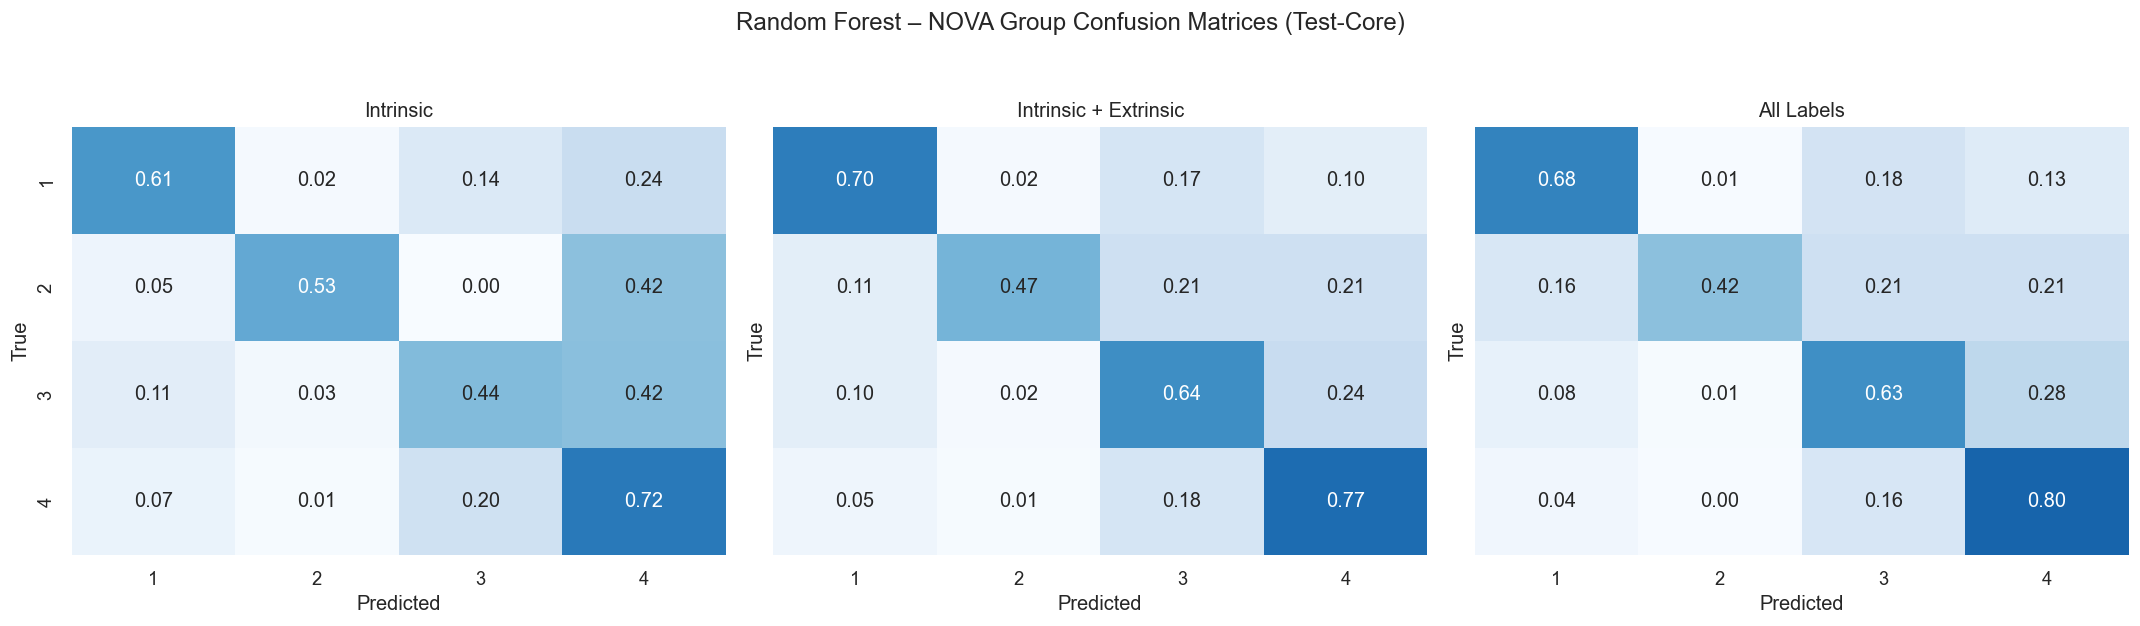

Saved: ../results\interpretability-nova\confusion_matrices\rf_cm_allphases_testcore_nova.png


In [5]:
# 2. Confusion Matrices (Test-Core)
cm_dir = os.path.join(INTERP_DIR, "confusion_matrices")
os.makedirs(cm_dir, exist_ok=True)

cms = []
for phase_name, phase_label in phases:
    col_pred = f"{phase_name}_rf_pred"
    y_true = test_core["nova_group"]
    y_pred = test_core[col_pred]

    cm = confusion_matrix(y_true, y_pred, labels=nova_classes, normalize="true")
    cms.append(cm)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

for ax, (phase_name, phase_label), cm in zip(axes, phases, cms):
    sns.heatmap(
        cm,
        ax=ax,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=nova_classes,
        yticklabels=nova_classes,
        cbar=False,
        vmin=0,
        vmax=1,
    )
    ax.set_title(f"{phase_label}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.suptitle("Random Forest – NOVA Group Confusion Matrices (Test-Core)", y=1.04)
plt.tight_layout()

cm_all_path = os.path.join(cm_dir, "rf_cm_allphases_testcore_nova.png")
plt.savefig(cm_all_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", cm_all_path)

Saved per-class metrics: ../results\interpretability-nova\per_class_metrics\rf_nova_per_class_metrics_testcore.csv


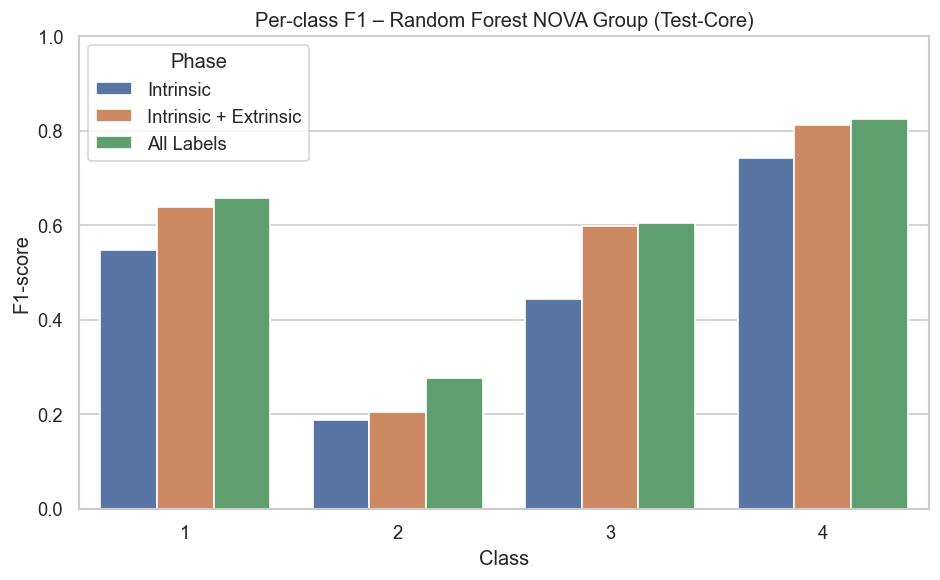

Saved: ../results\interpretability-nova\per_class_metrics\rf_nova_f1_per_class_testcore_allphases.png


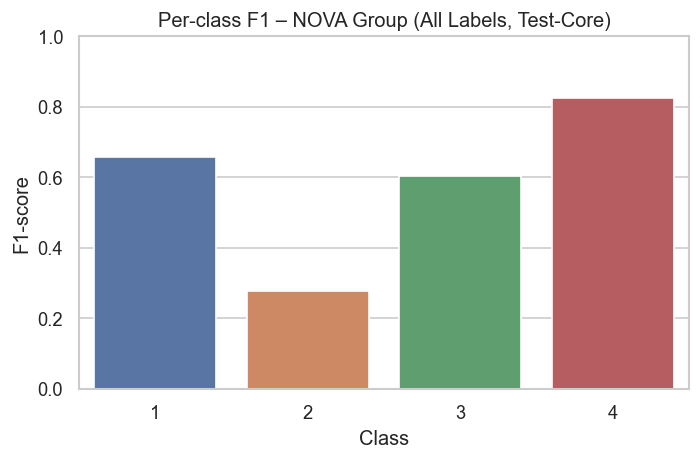

Saved: ../results\interpretability-nova\per_class_metrics\rf_nova_f1_per_class_testcore_bestphase.png


In [10]:
# 3. Per-Class Metrics & F1 Bars (Test-Core)

perclass_dir = os.path.join(INTERP_DIR, "per_class_metrics")
os.makedirs(perclass_dir, exist_ok=True)

perclass_list = []

for phase_name, phase_label in phases:
    col_pred = f"{phase_name}_rf_pred"
    y_true = test_core["nova_group"]
    y_pred = test_core[col_pred]

    precision, recall, f1, support = precision_recall_fscore_support(
        y_true,
        y_pred,
        labels=nova_classes,
        zero_division=0,
    )

    df_phase = pd.DataFrame({
        "Class": nova_classes,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "Support": support,
        "Phase": phase_label,
    })
    perclass_list.append(df_phase)

perclass_df = pd.concat(perclass_list, ignore_index=True)

perclass_csv = os.path.join(perclass_dir, "rf_nova_per_class_metrics_testcore.csv")
perclass_df.to_csv(perclass_csv, sep=";", index=False)
print("Saved per-class metrics:", perclass_csv)

# All phases: F1 per class
plt.figure(figsize=(8, 5))
sns.barplot(
    data=perclass_df,
    x="Class",
    y="F1",
    hue="Phase",
)
plt.ylim(0, 1)
plt.title("Per-class F1 – Random Forest NOVA Group (Test-Core)")
plt.ylabel("F1-score")
plt.tight_layout()

f1_all_path = os.path.join(perclass_dir, "rf_nova_f1_per_class_testcore_allphases.png")
plt.savefig(f1_all_path, dpi=300)
plt.show()
print("Saved:", f1_all_path)

# Best phase only
df_best = perclass_df[perclass_df["Phase"] == BEST_PHASE_LABEL]

plt.figure(figsize=(6, 4))
sns.barplot(
    data=df_best,
    x="Class",
    y="F1",
)
plt.ylim(0, 1)
plt.title(f"Per-class F1 – NOVA Group ({BEST_PHASE_LABEL}, Test-Core)")
plt.ylabel("F1-score")
plt.tight_layout()

f1_best_path = os.path.join(perclass_dir, "rf_nova_f1_per_class_testcore_bestphase.png")
plt.savefig(f1_best_path, dpi=300)
plt.show()
print("Saved:", f1_best_path)

In [12]:
# 4. Error Distribution for Best Phase
y_true_best = test_core["nova_group"]
y_pred_best = test_core[BEST_PRED_COL]

true_counts = y_true_best.value_counts().sort_index()
pred_counts = y_pred_best.value_counts().sort_index()

dist_df = pd.DataFrame({
    "True_count": true_counts,
    "Pred_count": pred_counts,
})
dist_df["Diff_pred_minus_true"] = dist_df["Pred_count"] - dist_df["True_count"]
dist_df["Rel_diff_%"] = 100 * dist_df["Diff_pred_minus_true"] / dist_df["True_count"]

print("True vs predicted distribution (Test-Core, best phase):")
display(dist_df.round(2))

cm_counts = confusion_matrix(y_true_best, y_pred_best, labels=nova_classes)
print("\nTop misclassification per true class:")

for i, cls in enumerate(nova_classes):
    row = cm_counts[i]
    total = row.sum()
    correct = row[i]
    if total == 0:
        continue

    mis = total - correct
    if mis == 0:
        print(f"  Class {cls}: perfectly classified ({total} samples)")
        continue

    wrong_indices = [j for j in range(len(nova_classes)) if j != i]
    top_wrong_idx = max(wrong_indices, key=lambda j: row[j])
    top_wrong_cls = nova_classes[top_wrong_idx]
    mis_rate = mis / total

    print(
        f"  True {cls}: {correct}/{total} correct, "
        f"{mis} misclassified ({mis_rate:.1%}), "
        f"most often predicted as {top_wrong_cls}"
    )

True vs predicted distribution (Test-Core, best phase):


,True_count,Pred_count,Diff_pred_minus_true,Rel_diff_%
1,552,593,41,7.43
2,19,39,20,105.26
3,1270,1398,128,10.08
4,3035,2846,-189,-6.23



Top misclassification per true class:
  True 1: 376/552 correct, 176 misclassified (31.9%), most often predicted as 3
  True 2: 8/19 correct, 11 misclassified (57.9%), most often predicted as 3
  True 3: 805/1270 correct, 465 misclassified (36.6%), most often predicted as 4
  True 4: 2422/3035 correct, 613 misclassified (20.2%), most often predicted as 3


Saved category metrics: ../results\interpretability-nova\category_level\rf_nova_testcore_per_category.csv


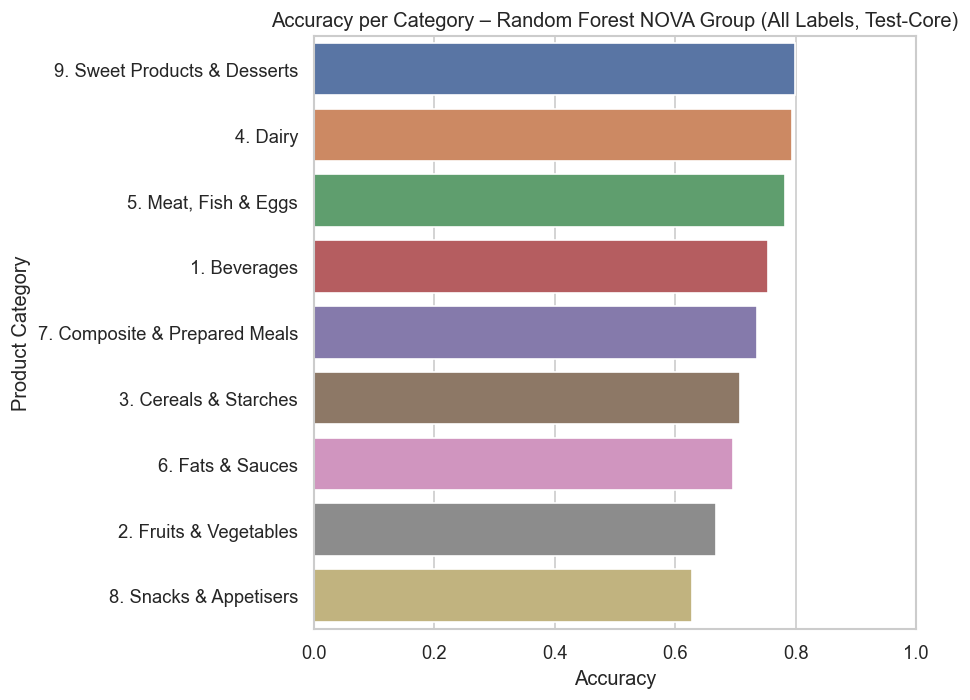

Saved: ../results\interpretability-nova\category_level\rf_nova_testcore_accuracy_per_category.png


In [14]:
# 5. Category-Level Performance (Test-Core)
assert "main_mapped_category" in test_core.columns

cat_dir = os.path.join(INTERP_DIR, "category_level")
os.makedirs(cat_dir, exist_ok=True)

df_cat = test_core.dropna(subset=["main_mapped_category"]).copy()
df_cat["y_true"] = df_cat["nova_group"]
df_cat["y_pred"] = df_cat[BEST_PRED_COL]

rows = []
for cat, subset in df_cat.groupby("main_mapped_category"):
    if len(subset) < 10:
        continue

    y_true = subset["y_true"]
    y_pred = subset["y_pred"]

    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro", zero_division=0)

    rows.append({
        "main_mapped_category": cat,
        "n_samples": len(subset),
        "Accuracy": acc,
        "F1_macro": f1m,
    })

cat_perf = pd.DataFrame(rows).sort_values("Accuracy", ascending=False)

cat_csv = os.path.join(cat_dir, "rf_nova_testcore_per_category.csv")
cat_perf.to_csv(cat_csv, sep=";", index=False)
print("Saved category metrics:", cat_csv)

plt.figure(figsize=(8, max(6, 0.3 * len(cat_perf))))
sns.barplot(
    data=cat_perf,
    y="main_mapped_category",
    x="Accuracy",
)
plt.xlim(0, 1)
plt.title(f"Accuracy per Category – Random Forest NOVA Group ({BEST_PHASE_LABEL}, Test-Core)")
plt.xlabel("Accuracy")
plt.ylabel("Product Category")
plt.tight_layout()

cat_acc_path = os.path.join(cat_dir, "rf_nova_testcore_accuracy_per_category.png")
plt.savefig(cat_acc_path, dpi=300)
plt.show()
print("Saved:", cat_acc_path)

In [16]:
print(cat_perf.to_string(index=False))

         main_mapped_category  n_samples  Accuracy  F1_macro
 9. Sweet Products & Desserts        744  0.799731  0.467973
                     4. Dairy        781  0.793854  0.533460
         5. Meat, Fish & Eggs        712  0.782303  0.529432
                 1. Beverages        597  0.753769  0.543376
7. Composite & Prepared Meals        314  0.735669  0.458273
        3. Cereals & Starches        342  0.707602  0.451623
             6. Fats & Sauces        287  0.696864  0.595242
       2. Fruits & Vegetables        647  0.667697  0.506609
       8. Snacks & Appetisers        452  0.628319  0.454731


Saved category×pred distribution: ../results\interpretability-nova\category_level\rf_nova_category_pred_distribution_testcore.csv


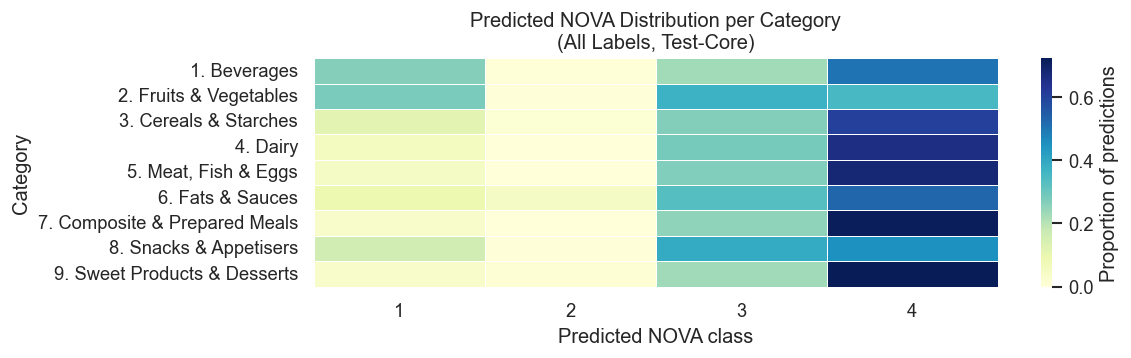

Saved: ../results\interpretability-nova\category_level\rf_nova_testcore_category_pred_heatmap.png


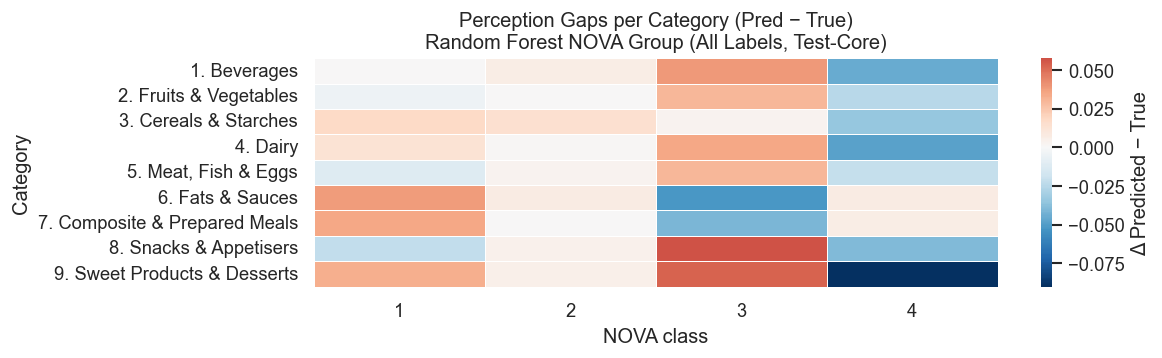

Saved: ../results\interpretability-nova\category_level\rf_nova_testcore_perception_gaps_heatmap.png


In [18]:
# 6. Category × Predicted Distribution & Perception Gaps
df_heat = df_cat.copy()

cat_pred_ct = pd.crosstab(
    index=df_heat["main_mapped_category"],
    columns=df_heat["y_pred"],
    normalize="index",
)

cat_pred_csv = os.path.join(cat_dir, "rf_nova_category_pred_distribution_testcore.csv")
cat_pred_ct.to_csv(cat_pred_csv, sep=";")
print("Saved category×pred distribution:", cat_pred_csv)

plt.figure(figsize=(10, 0.35 * len(cat_pred_ct)))
sns.heatmap(
    cat_pred_ct,
    cmap="YlGnBu",
    linewidths=0.3,
    linecolor="white",
    cbar_kws={'label': 'Proportion of predictions'},
)
plt.title(f"Predicted NOVA Distribution per Category\n({BEST_PHASE_LABEL}, Test-Core)")
plt.xlabel("Predicted NOVA class")
plt.ylabel("Category")
plt.tight_layout()

cat_pred_png = os.path.join(cat_dir, "rf_nova_testcore_category_pred_heatmap.png")
plt.savefig(cat_pred_png, dpi=300)
plt.show()
print("Saved:", cat_pred_png)

# Perception gaps (Pred − True)
true_ct = pd.crosstab(
    index=df_heat["main_mapped_category"],
    columns=df_heat["y_true"],
    normalize="index",
)

all_classes = sorted(set(true_ct.columns) | set(cat_pred_ct.columns))
true_ct = true_ct.reindex(columns=all_classes, fill_value=0)
pred_ct = cat_pred_ct.reindex(columns=all_classes, fill_value=0)

diff_ct = pred_ct - true_ct

true_ct.to_csv(os.path.join(cat_dir, "rf_nova_true_distribution_testcore.csv"), sep=";")
pred_ct.to_csv(os.path.join(cat_dir, "rf_nova_pred_distribution_testcore.csv"), sep=";")
diff_ct.to_csv(os.path.join(cat_dir, "rf_nova_perception_gap_testcore.csv"), sep=";")

plt.figure(figsize=(10, 0.35 * len(diff_ct)))
sns.heatmap(
    diff_ct,
    cmap="RdBu_r",
    center=0,
    linewidths=0.3,
    linecolor="white",
    cbar_kws={'label': 'Δ Predicted − True'},
)
plt.title(f"Perception Gaps per Category (Pred − True)\nRandom Forest NOVA Group ({BEST_PHASE_LABEL}, Test-Core)")
plt.xlabel("NOVA class")
plt.ylabel("Category")
plt.tight_layout()

gap_png = os.path.join(cat_dir, "rf_nova_testcore_perception_gaps_heatmap.png")
plt.savefig(gap_png, dpi=300)
plt.show()
print("Saved:", gap_png)